In [115]:
 !pip install wget
 !pip install opencv-python

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [22]:
seed=42

In [23]:
import os
from os.path import exists
import sys
import requests
import zipfile
import wget
cwd = os.getcwd()
train_dir='inaturalist_12K/train/' 
test_dir='inaturalist_12K/val/'
savePath=cwd+'/DataSet/'
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

In [24]:
file_exists = exists(cwd+'/DataSet/nature_12K.zip')
if(file_exists==False):
    url='https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
    print('Downloading..')
    wget.download(url,savePath)
    
extract_exists = exists(cwd+'/DataSet/inaturalist_12K')   
if(extract_exists==False):   
    savePath=cwd+'\\DataSet'
    savefile=cwd+'\\DataSet\\nature_12K.zip'
    print('Extracting..')
    with zipfile.ZipFile(savefile, 'r') as zip_ref:
        zip_ref.extractall(savePath)
    print('Finished..')
   
    

### Download and Extract 

In [25]:
train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

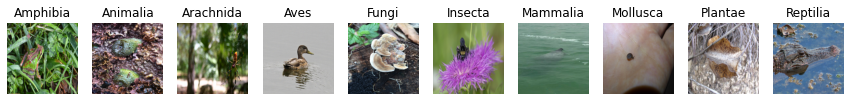

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import cv2
imagePath=os.getcwd()+'\\DataSet\\inaturalist_12K\\train'
listImages=[]
columns = 5
rows = 5
imcount=1

for i in classes:
    p=imagePath+'\\'+i
    files=os.listdir( p)
    img=random.choice(files)
    imgplt=mpimg.imread( p+'\\'+str(img))
    imgplt=cv2.resize(imgplt,(300,300)) 
    listImages.append(imgplt)
    #plt.imshow(imgplt)
    #fig.add_subplot(rows, columns, imcount)
    #imcount+=1
    #plt.axis('off')
    #plt.title(i) 

_, axs = plt.subplots(1, 10, figsize=(15, 15))
axs = axs.flatten()
for img, ax,cls in zip(listImages, axs,classes):
  
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(str(cls))
plt.show()

In [27]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPool2D,MaxPooling3D , Flatten , Dropout, Dense, Activation, BatchNormalization


In [33]:
"""
Import inaturalist before training the model. 
"""
def Import_dataset(seed,augment_data=False):
    #All variables 
    cwd=os.getcwd()
    batchsize=32
    image_size=300
    train_dir = cwd+'\\DataSet\\inaturalist_12K\\train\\'
    test_dir = cwd+'\\DataSet\\inaturalist_12K\\val\\'
    print('Training Dataset')
    
    #perform Augmentation if augment_data=True
    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=90,
                                      zoom_range=0.2,
                                      shear_range=0.2,
                                      validation_split=0.1,
                                      horizontal_flip=True)
        test_datagen = ImageDataGenerator(rescale=1./255)
    else:
        train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
        test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_ds = train_datagen.flow_from_directory(train_dir,subset="training", class_mode='sparse',color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
    val_ds = train_datagen.flow_from_directory(train_dir,subset="validation",class_mode='sparse', color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
    print('')
    print('Test Dataset')
    test_ds = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size),class_mode='sparse',color_mode='rgb',batch_size=30)
   
    
    
    
  
    return train_ds,val_ds, test_ds

### Model consisting of 5 convolution layers

In [34]:
"""
Following functions used to construct an CNN network

Parameters
---------
BatchNormalization: If true apply batch normalisation after each layer

"""

def CNN(filters, size_of_filters,\
        activation_function,\
        number_of_neurons_dense_layer,\
        number_of_classes,\
        dropout=0,\
        BatchNormalization=True,
        filterSize=32,
        filterOrganization=[]
       ):
    imsize=300
    if(filterOrganization=='all_same'):
        filters=[filterSize,filterSize,filterSize,filterSize,filterSize]
    if(filterOrganization=='incr'):
        filters=[filterSize,filterSize*2,4*filterSize,8*filterSize,16*filterSize]
    if(filterOrganization=='dect'):
        filters=[filterSize,filterSize/2,filterSize/4,filterSize/8,filterSize/16]
    if(filterOrganization=='alt_incr'):
        filters=[filterSize,filterSize*2,filterSize,filterSize*2,filterSize]     
    if(filterOrganization=='alt_decr'):
        filters=[filterSize,filterSize/2,filterSize,filterSize/2,filterSize]
        
    model = Sequential()
    num_of_filters=len(filters)
    model.add(Conv2D(filters[0], size_of_filters[0],input_shape=(imsize,imsize,3)))
    if BatchNormalization:
            model.add(tf.keras.layers.BatchNormalization()) #momentum= 0.99
    model.add(MaxPooling2D((2,2)))
    
    for i in range(num_of_filters-1):
        model.add(Conv2D(no_of_filters[i+1], size_of_filters[i+1]))
        
        model.add(Activation(activation_function[i]))
        if BatchNormalization:
            model.add(tf.keras.layers.BatchNormalization()) #momentum= 0.99
        model.add(MaxPooling2D((2,2)))
       
       
    model.add(Flatten())

    model.add(Dense(number_of_neurons_dense_layer,activation=activation_function[-2])) 
    if BatchNormalization:
            model.add(tf.keras.layers.BatchNormalization()) #momentum= 0.99
    if(dropout>0):
        model.add(Dropout(dropout))
    model.add(Dense(number_of_classes, activation=activation_function[-1]))
    return model



In [35]:
train_ds,val_ds,test_ds=Import_dataset(seed=42,augment_data=True)

Training Dataset
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.

Test Dataset
Found 2000 images belonging to 10 classes.


In [36]:
#sample inputs
#no_of_filters = [64,64,64,64,64]
size_of_filters = [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
activation_function = ['relu','relu','relu','relu','relu','relu','softmax']
number_of_neurons_in_the_dense_layer = 256
dropout=0.3
number_of_classes=10
model=CNN(no_of_filters,size_of_filters,\
          activation_function,\
          number_of_neurons_in_the_dense_layer,\
          number_of_classes,\
          dropout,\
          filterSize=16,\
         filterOrganization='incr') 

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(),\
              loss=[tf.keras.losses.SparseCategoricalCrossentropy()],\
              metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
hist=model.fit(train_ds, epochs=10,validation_data=test_ds)

Epoch 1/10
282/282 [==============================] - 1012s 4s/step - loss: 2.4010 - accuracy: 0.2261 - val_loss: 2.6752 - val_accuracy: 0.1175
Epoch 2/10
282/282 [==============================] - 1019s 4s/step - loss: 2.1312 - accuracy: 0.2633 - val_loss: 1.9346 - val_accuracy: 0.3325
Epoch 3/10
282/282 [==============================] - 943s 3s/step - loss: 2.0177 - accuracy: 0.3010 - val_loss: 2.1697 - val_accuracy: 0.2945
Epoch 4/10
282/282 [==============================] - 764s 3s/step - loss: 1.9319 - accuracy: 0.3283 - val_loss: 2.2901 - val_accuracy: 0.2690
Epoch 5/10
282/282 [==============================] - 772s 3s/step - loss: 1.8861 - accuracy: 0.3347 - val_loss: 1.8649 - val_accuracy: 0.3610
Epoch 6/10
282/282 [==============================] - 758s 3s/step - loss: 1.8351 - accuracy: 0.3486 - val_loss: 1.8993 - val_accuracy: 0.3570
Epoch 7/10
282/282 [==============================] - 746s 3s/step - loss: 1.8089 - accuracy: 0.3636 - val_loss: 1.8740 - val_accuracy: 0.35

In [38]:
model.evaluate(test_ds)

67/67 [==============================] - 41s 616ms/step - loss: 1.7516 - accuracy: 0.3880


[1.751618504524231, 0.3880000114440918]

In [40]:
model.save(cwd+'\\models\\')

INFO:tensorflow:Assets written to: C:\Users\cseka\DL Assignment2\models\assets


In [55]:
model=keras.models.load_model(cwd+'\\models\\')